# Machine Learning - Final project
### Empathy Prediction using the [Young people survey](https://www.kaggle.com/miroslavsabo/young-people-survey/) dataset

#### Loading datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *

sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})  
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [2]:
df = pd.read_csv('./input/responses.csv')
columns_desc = pd.read_csv('./input/columns.csv')

In [3]:
df.shape

(1010, 150)

#### Defining way to access description easily

In [4]:
all_columns =list(df)

desc = {}
for col_name in all_columns:
    desc[col_name] = columns_desc.loc[columns_desc['short'] == col_name].iloc[0][0]
    
def print_desc(column_name):
    print(column_name+" --> "+desc[column_name])

Example:

In [5]:
for col in all_columns[:5]:
    print_desc(col)

Music --> I enjoy listening to music.
Slow songs or fast songs --> I prefer.
Dance --> Dance, Disco, Funk
Folk --> Folk music
Country --> Country


## Data Exploration and preprocessing

In [6]:
df.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1007.000000,1008.000000,1006.000000,1005.000000,1005.000000,1003.000000,1008.000000,1007.000000,1004.000000,1007.000000,1002.000000,1006.000000,1003.000000,1004.000000,1003.000000,1003.000000,1002.000000,1003.000000,1009.000000,1004.000000,1008.000000,1009.000000,1007.000000,1007.000000,1008.000000,1008.000000,1007.000000,1007.000000,1002.000000,1006.000000,1008.000000,1008.000000,1005.000000,1009.000000,1007.000000,1007.000000,1006.000000,1004.000000,1005.000000,1004.000000,1000.000000,1004.000000,1001.000000,1005.000000,1005.000000,1009.000000,1006.000000,1004.000000,1007.000000,1003.000000,1007.000000,1009.000000,1004.000000,995.000000,1006.000000,1003.000000,1008.000000,1008.000000,1004.000000,1002.000000,1006.000000,1007.000000,1006.00000,1007.000000,1009.000000,1008.000000,1007.000000,1005.000000,1010.000000,1007.000000,1009.000000,1009.000000,1009.000000,1007.000000,1003.000000,1005.000000,1007.000000,1005.000000,1007.000000,1003.000000,1006.000000,1009.000000,1006.000000,1004.000000,1006.000000,1009.000000,1003.000000,1006.000000,1007.000000,1005.000000,1006.000000,1006.000000,1005.000000,1010.000000,1004.000000,1003.000000,1008.000000,1009.000000,1006.000000,1009.000000,1008.000000,1008.000000,1010.000000,1007.000000,1010.000000,1007.000000,1008.000000,1006.000000,1007.000000,1005.000000,1008.000000,1004.000000,1006.000000,1008.000000,1006.000000,1008.000000,1008.000000,1007.000000,1007.000000,1006.000000,1005.000000,1006.000000,1006.000000,1006.000000,1005.000000,1007.000000,1008.000000,1006.000000,1007.000000,1008.000000,1008.000000,1007.000000,1007.000000,1010.000000,1008.00000,1003.000000,990.000000,990.000000,1004.000000
mean,4.731877,3.328373,3.113320,2.288557,2.123383,2.956132,2.761905,3.471698,3.761952,2.361470,2.456088,2.910537,2.769691,2.759960,3.141575,2.828514,2.842315,2.338983,2.139742,4.613546,2.793651,3.383548,4.494538,3.489573,3.113095,3.155754,3.749752,3.788481,3.643713,2.126243,3.536706,3.207341,3.138308,2.595639,2.334657,2.064548,4.175944,3.136454,2.643781,2.665339,2.165000,3.159363,3.082917,3.778109,2.516418,2.256690,2.686879,2.589641,2.273088,3.686939,2.461768,2.324083,1.901394,3.387940,3.291252,1.907278,2.362103,3.276786,3.234064,3.024950,4.557654,2.948361,3.33499,2.061569

In [7]:
df.rename(columns={'Left - right handed': 'LeftRightHanded', 'Village - town': 'VillageTown', 'Internet usage': 'InternetUsage', 'Only child': 'OnlyChild', 'House - block of flats': 'HouseFlats'}, inplace=True)

In [8]:
all_columns =list(df)

I notice that some attributes like Music have really skewed distributions, later on I could try to apply some log transformations and compare the performances

### Missing values

Let's start by looking at how many rows are missing a class label, I will delete these rows since it makes no sense to impute them, train or test using them

In [9]:
df['Empathy'].isna().sum()

5

In [10]:
df.dropna(subset=['Empathy'], inplace=True)

In [11]:
df.shape

(1005, 150)

Let's now look at the percentage of missing values in all columns in desc order

In [12]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': df_na})
missing_data.head(150).T

,Height,Weight,Passive sport,Chemistry,Geography,Theatre,Documentary,Smoking,Latino,Punk,Criminal damage,Compassion to animals,Final judgement,"Reggae, Ska",Gardening,Alternative,Rock n roll,"Techno, Trance",Age,Classical music,"Swing, Jazz",Movies,Biology,Reading,Giving,PC,Gender,Number of siblings,Responding to a serious letter,Daily events,Science and technology,Art exhibitions,Friends versus money,Writing,"Countryside, outdoors",Rock,Folk,Self-criticism,Spiders,Country,Economy Management,Energy levels,Workaholism,Psychology,Foreign languages,Prioritising workload,Getting up,Medicine,Alcohol,Socializing,VillageTown,Pets,Active sport,Reliability,Loss of interest,Fun with friends,Cars,HouseFlats,Funniness,Decision making,Dance,"Hiphop, Rap",Questionnaires or polls,Finding lost valuables,Personality,Small - big dogs,Happiness in life,Getting angry,Children,Mood swings,Western,Internet,Cheating in school,Hypochondria,Judgment calls,Romantic,Comedy,Fantasy/Fairy tales,Animated,Religion,Physics,Dancing,Metal or Hardrock,Pop,Mathematics,Music,Appearence and gestures,Spending on looks,Life struggles,Interests or hobbies,Charity,Finances,Elections,Thinking ahead,Writing notes,Healthy eating,Entertainment spending,Rats,Heights,LeftRightHanded,Waiting,Flying,Adrenaline sports,Unpopularity,Public speaking,Horror,Assertiveness,Knowing the right people,Achievements,Celebrities,Parents' advice,Shopping centres,Sci-fi,Spending on healthy eating,OnlyChild,Slow songs or fast songs,Branded clothing,Lying,War,Shopping,Punctuality,Action,History,God,Changing the past,Darkness,New environment,Borrowed stuff,Dangerous dogs,Storm,Musical instruments,Education,Ageing,Musical,Loneliness,Law,Keeping promises,Fake,Health,Politics,Opera,Thriller,Fear of public speaking
Missing Ratio,1.99005,1.99005,1.492537,0.995025,0.895522,0.79602,0.79602,0.79602,0.79602,0.79602,0.696517,0.696517,0.696517,0.696517,0.696517,0.696517,0.696517,0.696517,0.696517,0.696517,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.597015,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.497512,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.39801,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.298507,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.199005,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502,0.099502


The percentage of missing values is not a lot, we can easily impute them without introducing too much bias by using the mode

In [13]:
df[all_columns]=df[all_columns].fillna(df.mode().iloc[0])

In [14]:
df.isnull().any().any()

False

There are no missing values now

### Data types

In [15]:
df.dtypes[:10]

Music                       float64
Slow songs or fast songs    float64
Dance                       float64
Folk                        float64
Country                     float64
Classical music             float64
Musical                     float64
Pop                         float64
Rock                        float64
Metal or Hardrock           float64
dtype: object

In [16]:
float_cols = df.dtypes == np.float64

In [17]:
fake_float = list(df.loc[:, float_cols])

In [18]:
len(fake_float)

134

134 columns are float but should be int since the decimal value is always 0, let's convert them

In [19]:
df[fake_float] = df[fake_float].astype(int)

### One hot encoding
Since the algorithms that I have in mind do not handle categorical values I will need to perform one hot encoding or encode values in numbers for ordinal data

Let's look at categorical columns and decide which ones can be ordinal

In [20]:
categorical = df.dtypes == np.object

In [21]:
df.loc[:, categorical].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
Smoking,never smoked,never smoked,tried smoking,former smoker,tried smoking,never smoked,tried smoking,current smoker,tried smoking,never smoked,current smoker,tried smoking,tried smoking,never smoked,current smoker,former smoker,current smoker,tried smoking,tried smoking,former smoker,never smoked,tried smoking,tried smoking,tried smoking,tried smoking,tried smoking,tried smoking,never smoked,former smoker,tried smoking,former smoker,tried smoking,current smoker,tried smoking,tried smoking,tried smoking,never smoked,former smoker,tried smoking,never smoked,never smoked,tried smoking,never smoked,tried smoking,current smoker,never smoked,current smoker,tried smoking,current smoker,tried smoking,tried smoking,never smoked,current smoker,tried smoking,current smoker,current smoker,current smoker,current smoker,never smoked,current smoker,tried smoking,current smoker,never smoked,tried smoking,former smoker,tried smoking,tried smoking,never smoked,tried smoking,tried smoking,former smoker,tried smoking,former smoker,former smoker,tried smoking,...,tried smoking,tried smoking,never smoked,former smoker,never smoked,tried smoking,current smoker,tried smoking,current smoker,never smoked,current smoker,tried smoking,tried smoking,tried smoking,tried smoking,never smoked,former smoker,never smoked,tried smoking,former smoker,current smoker,current smoker,never smoked,tried smoking,current smoker,never smoked,tried smoking,never smoked,current smoker,tried smoking,tried smoking,tried smoking,never smoked,tried smoking,former smoker,current smoker,tried smoking,tried smoking,current smoker,current smoker,current smoker,tried smoking,current smoker,tried smoking,never smoked,tried smoking,tried smoking,tried smoking,tried smoking,current smoker,former smoker,tried smoking,current smoker,tried smoking,former smoker,former smoker,tried smoking,never smoked,former smoker,current smoker,tried smoking,former smoker,tried smoking,tried smoking,never smoked,never smoked,former smoker,current smoker,former smoker,former smoker,current smoker,never smoked,tried smoking,tried smoking,tried smoking
Alcohol,drink a lot,drink a lot,drink a lot,drink a lot,social drinker,never,social drinker,drink a lot,social drinker,drink a lot,social drinker,never,social drinker,social drinker,social drinker,social drinker,drink a lot,social drinker,social drinker,drink a lot,never,social drinker,social drinker,social drinker,never,social drinker,social drinker,social drinker,social drinker,social drinker,drink a lot,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,never,social drinker,social drinker,never,drink a lot,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,never,social drinker,social drinker,social drinker,drink a lot,drink a lot,drink a lot,social drinker,drink a lot,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,social drinker,never,drink a lot,social drinker,social drinker,never,social drinker,social drinker,social drinker,...,social drinker,social drinker,social drinker,social drinker,never,never,social drinker,drink a lot,social drinker,social drinker,drink a lot,social drinker,social drinker,social drinker,social drinker,never,drink a lot,never,social drinker,social drinker,drink a lot,drink a lot,social drinker,social drinker,social drinker,social drinker,social

In [22]:
categorical_cols = list(df.loc[:, categorical])

In [23]:
categorical_cols

['Smoking',
 'Alcohol',
 'Punctuality',
 'Lying',
 'InternetUsage',
 'Gender',
 'LeftRightHanded',
 'Education',
 'OnlyChild',
 'VillageTown',
 'HouseFlats']

There are a lot of ordinal columns, which is better because we will not occur in a feature explosion using OHE, I think the ordinal values could be:

* Punctuality
* InternetUsage
* Education

Some other that only have True/False or Yes/No or in general 2 possible values can be encoded using the same attribute and an integer value (0 or 1), these features are:

* Gender
* LeftRightHanded
* OnlyChild
* VillageTown
* HouseFlats

The remaining categorical attributes are the ones that I think are the most important to predict empathy or that are not really ordinal and I would not want to introduce a bias by considering them as ordinal, these attributes are:

* Smoking
* Lying
* Alcohol

In [24]:
print("Unique values of Smoking")
print(df.Smoking.unique())

print("\nUnique values of Lying")
print(df.Lying.unique())


Unique values of Smoking
['never smoked' 'tried smoking' 'former smoker' 'current smoker']

Unique values of Lying
['never' 'sometimes' 'only to avoid hurting someone'
 'everytime it suits me']


In [25]:
df.shape

(1005, 150)

In [26]:
def OHE_Smoking_N(value):
    return 1 if value=='never smoked' else 0

def OHE_Smoking_T(value):
    return 1 if value=='tried smoking' else 0

def OHE_Smoking_F(value):
    return 1 if value=='former smoker' else 0

def OHE_Smoking_C(value):
    return 1 if value=='current smoker' else 0

In [27]:
df['Smoking_Never'] = df.Smoking.apply(OHE_Smoking_N)
df['Smoking_Tried'] = df.Smoking.apply(OHE_Smoking_T)
df['Smoking_Former'] = df.Smoking.apply(OHE_Smoking_F)
df['Smoking_Current'] = df.Smoking.apply(OHE_Smoking_C)

In [28]:
def OHE_Lying_N(value):
    return 1 if value=='never' else 0

def OHE_Lying_S(value):
    return 1 if value=='sometimes' else 0

def OHE_Lying_O(value):
    return 1 if value=='only to avoid hurting someone' else 0

def OHE_Lying_E(value):
    return 1 if value=='everytime it suits me' else 0

In [29]:
df['Lying_Never'] = df.Lying.apply(OHE_Lying_N)
df['Lying_Sometimes'] = df.Lying.apply(OHE_Lying_S)
df['Lying_Only'] = df.Lying.apply(OHE_Lying_O)
df['Lying_Everytime'] = df.Lying.apply(OHE_Lying_E)

In [30]:
def OHE_Alcohol_D(value):
    return 1 if value=='drink a lot' else 0

def OHE_Alcohol_S(value):
    return 1 if value=='social drinker' else 0

def OHE_Alcohol_N(value):
    return 1 if value=='never' else 0

In [31]:
df['Alcohol_Drink'] = df.Alcohol.apply(OHE_Alcohol_D)
df['Alcohol_Social'] = df.Alcohol.apply(OHE_Alcohol_S)
df['Alcohol_Never'] = df.Alcohol.apply(OHE_Alcohol_N)

#### True False OHE

In [32]:
def OHE_Male(value):
    return 1 if value=='male' else 0

In [33]:
df['Male'] = df.Gender.apply(OHE_Male)

In [34]:
def OHE_Right(value):
    return 1 if value=='right handed' else 0

In [35]:
df['Right_Handed'] = df.LeftRightHanded.apply(OHE_Right)

In [36]:
def OHE_Only(value):
    return 1 if value=='yes' else 0

In [37]:
df['Only_Child'] = df.OnlyChild.apply(OHE_Only)

In [38]:
def OHE_City(value):
    return 1 if value=='city' else 0

In [39]:
df['City'] = df.VillageTown.apply(OHE_City)

In [40]:
def OHE_House(value):
    return 1 if value=='house/bungalow' else 0

In [41]:
df['House'] = df.HouseFlats.apply(OHE_House)

#### Ordinal

In [42]:
print("Unique values of Punctuality")
print(df.Punctuality.unique())

Unique values of Punctuality
['i am always on time' 'i am often early' 'i am often running late']


In [43]:
def OHE_Punctuality_Ordinal(value):
    if value=='i am always on time':
        return 1
    if value=='i am often early':
        return 2 
    if value=='i am often running late':
        return 0
    #should not arrive here
    return 0

In [44]:
df['Punctual'] = df.Punctuality.apply(OHE_Punctuality_Ordinal)

In [45]:
print("Unique values of InternetUsage")
print(df.InternetUsage.unique())

Unique values of InternetUsage
['few hours a day' 'most of the day' 'less than an hour a day'
 'no time at all']


In [46]:
def OHE_InternetUsage_Ordinal(value):
    if value=='most of the day':
        return 3
    if value=='few hours a day':
        return 2 
    if value=='less than an hour a day':
        return 1
    if value=='no time at all':
        return 0
    #should not arrive here
    return 0

In [47]:
df['InternetUsage'] = df.InternetUsage.apply(OHE_InternetUsage_Ordinal)

In [48]:
print("Unique values of Education")
print(df.Education.unique())

Unique values of Education
['college/bachelor degree' 'secondary school' 'primary school'
 'masters degree' 'doctorate degree' 'currently a primary school pupil']


In [49]:
def OHE_Education_Ordinal(value):
    if value=='doctorate degree':
        return 5
    if value=='masters degree':
        return 4 
    if value=='college/bachelor degree':
        return 3
    if value=='secondary school':
        return 2
    if value=='primary school':
        return 1
    if value=='currently a primary school pupil':
        return 0
    #should not arrive here
    return 0

In [50]:
df['Education'] = df.Education.apply(OHE_Education_Ordinal)

#### Deleting categorical columns that were encoded

In [51]:
encoded_columns = ['Smoking','Lying','Alcohol','Gender','LeftRightHanded','OnlyChild','VillageTown','HouseFlats','Punctuality']

In [52]:
df = df.drop(encoded_columns, axis=1)

In [53]:
df.shape

(1005, 158)

In [54]:
pd.options.display.max_columns = 158
pd.options.display.max_rows = 158

In [55]:
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,InternetUsage,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings,Education,Smoking_Never,Smoking_Tried,Smoking_Former,Smoking_Current,Lying_Never,Lying_Sometimes,Lying_Only,Lying_Everytime,Alcohol_Drink,Alcohol_Social,Alcohol_Never,Male,Right_Handed,Only_Child,City,House,Punctual
0,5,3,2,1,2,2,1,5,5,1,1,1,1,1,3,1,1,1,1,5,4,2,5,4,4,1,5,5,3,1,2,1,5,1,3,3,5,3,5,3,3,3,3,5,3,1,1,1,1,5,3,3,2,1,5,5,1,4,4,2,5,4,4,1,1,1,1,1,5,3,1,3,2,4,2,2,5,4,2,5,4,4,1,3,5,1,1,3,4,1,3,1,3,1,4,5,4,3,2,1,1,1,4,2,3,3,4,3,4,3,4,3,5,1,1,3,5,5,1,4,5,1,4,3,2,3,4,3,2,3,4,5,3,3,1,3,20,163,48,1,3,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,4,4,2,1,1,1,2,3,5,4,4,1,3,1,4,4,2,1,1,5,2,2,4,3,4,1,3,5,4,1,4,1,3,4,5,2,4,4,5,1,1,4,4,5,1,2,2,2,1,1,1,1,1,1,1,1,2,3,3,2,4,2,5,1,1,1,2,1,1,1,3,1,4,3,3,2,4,5,4,1,4,4,3,4,3,2,1,2,5,4,4,1,2,1,2,4,3,2,4,4,4,1,3,1,3,3,4,4,4,4,2,4,2,2,5,4,4,4,1,4,3,5,3,4,5,3,2,3,2,3,4,1,4,2,5,2,19,163,58,2,3,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,2
2,5,5,2,2,3,4,5,3,5,3,4,1,4,3,5,5,5,1,3,5,3,4,4,2,4,2,5,5,2,2,1,1,2,1,5,2,4,2,4,1,1,5,2,5,2,3,1,5,5,5,5,5,5,5,2,1,1,4,2,5,5,5,5,1,1,1,1,1,1,1,1,1,2,3,1,2,5,3,5,3,4,5,1,5,2,4,1,3,5,4,4,1,5,5,5,4,2,5,3,2,5,5,1,3,3,2,3,4,3,5,3,4,4,3,4,3,2,4,4,4,4,3,3,3,4,5,3,1,2,2,4,1,4,3,4,2,20,176,67,2,2,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
3,5,3,2,1,1,1,1,2,2,1,4,2,2,1,2,5,1,2,1,5,4,4,3,3,4,3,1,2,5,1,2,4,4,5,4,1,3,1,2,3,3,5,4,4,2,5,1,5,4,1,1,1,3,1,1,1,2,4,3,1,2,1,1,2,1,1,3,5,5,5,4,5,5,3,4,4,4,5,3,1,3,4,5,2,1,1,5,5,5,5,4,3,3,1,1,2,5,5,5,1,5,4,3,3,1,1,1,5,3,1,3,3,2,5,5,4,5,3,3,2,2,1,2,1,1,3,2,4,3,2,4,3,3,4,4,1,22,172,59,1,3,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,1,2
4,5,3,4,3,2,4,3,5,3,1,2,5,3,2,1,2,4,2,2,5,4,4,5,2,3,3,4,4,3,1,4,3,2,3,2,2,2,2,2,3,3,5,2,3,3,2,3,1,4,4,1,3,1,3,1,4,3,3,3,2,4,2,1,1,2,1,1,1,1,2,2,4,3,4,3,1,2,3,5,5,5,4,2,3,3,2,1,3,5,5,5,1,3,1,3,3,4,3,5,3,4,5,3,3,3,3,4,2,3,3,3,3,5,4,2,3,5,5,2,3,5,3,3,2,4,3,3,3,2,4,3,4,3,3,2,4,20,170,59,1,2,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1


### Exploring relevant features

In [56]:
all_columns =list(df)

In [57]:
%matplotlib inline

In [70]:
df.shape[1]

158

In [71]:
t = ['ciao']

In [81]:
cov = {}
for col in all_columns:
    if col != 'Empathy':
        l = ['Empathy']
        l.append(col)
        cov[col] = df['Empathy'].corr(df[col])

In [83]:
import operator
sorted_cov = sorted(cov.items(), key=operator.itemgetter(1))

In [89]:
most_correlated = []
for item in sorted_cov[:5]:
    most_correlated.append(item[0])
for item in sorted_cov[-5:]:
    most_correlated.append(item[0])
most_correlated

['Male',
 'Weight',
 'Cars',
 'Fake',
 'Height',
 'Latino',
 'Fantasy/Fairy tales',
 'Children',
 'Judgment calls',
 'Life struggles']

### Matrix correlation for the 10 features which are correlated the most to Empathy

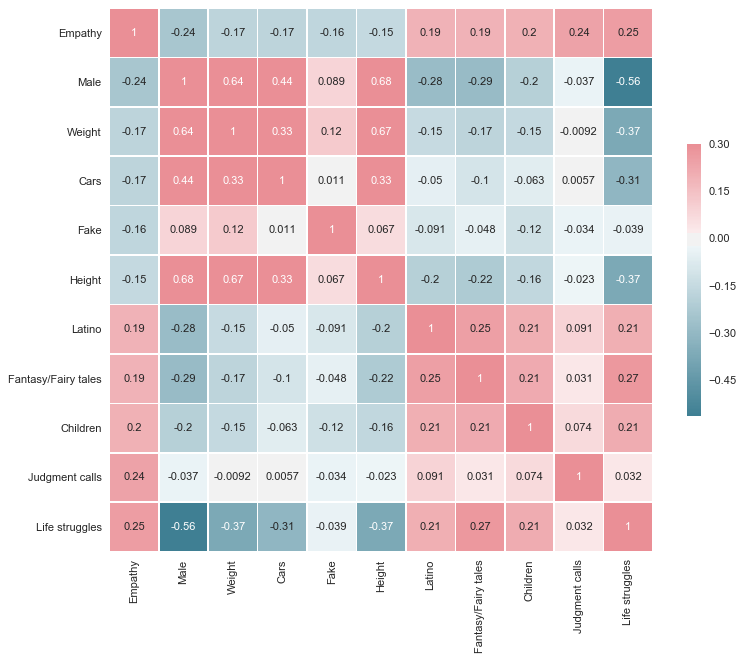

In [94]:

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    covariance,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    annot=True,
    linewidths=.5,
    cbar_kws={"shrink": .5})

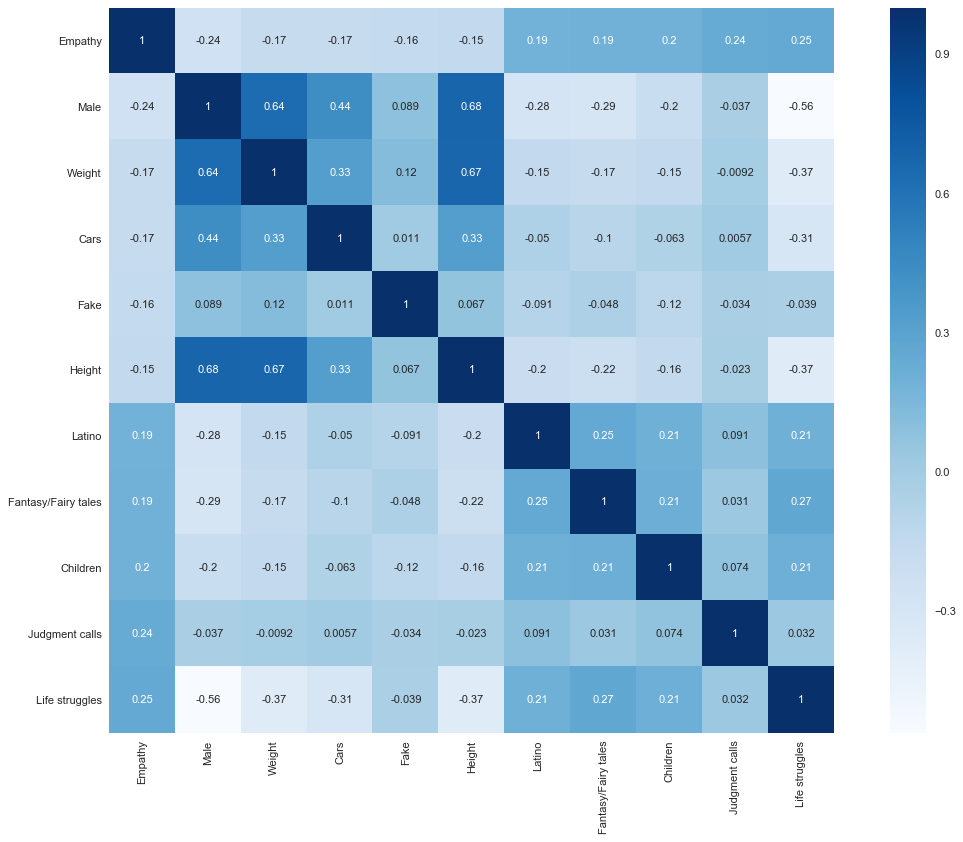

In [90]:
covariance=df[['Empathy']+most_correlated].corr(method='pearson')
sns.heatmap(covariance,square=True,annot=True,cmap="Blues")

In [95]:
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,InternetUsage,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings,Education,Smoking_Never,Smoking_Tried,Smoking_Former,Smoking_Current,Lying_Never,Lying_Sometimes,Lying_Only,Lying_Everytime,Alcohol_Drink,Alcohol_Social,Alcohol_Never,Male,Right_Handed,Only_Child,City,House,Punctual
0,5,3,2,1,2,2,1,5,5,1,1,1,1,1,3,1,1,1,1,5,4,2,5,4,4,1,5,5,3,1,2,1,5,1,3,3,5,3,5,3,3,3,3,5,3,1,1,1,1,5,3,3,2,1,5,5,1,4,4,2,5,4,4,1,1,1,1,1,5,3,1,3,2,4,2,2,5,4,2,5,4,4,1,3,5,1,1,3,4,1,3,1,3,1,4,5,4,3,2,1,1,1,4,2,3,3,4,3,4,3,4,3,5,1,1,3,5,5,1,4,5,1,4,3,2,3,4,3,2,3,4,5,3,3,1,3,20,163,48,1,3,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,4,4,2,1,1,1,2,3,5,4,4,1,3,1,4,4,2,1,1,5,2,2,4,3,4,1,3,5,4,1,4,1,3,4,5,2,4,4,5,1,1,4,4,5,1,2,2,2,1,1,1,1,1,1,1,1,2,3,3,2,4,2,5,1,1,1,2,1,1,1,3,1,4,3,3,2,4,5,4,1,4,4,3,4,3,2,1,2,5,4,4,1,2,1,2,4,3,2,4,4,4,1,3,1,3,3,4,4,4,4,2,4,2,2,5,4,4,4,1,4,3,5,3,4,5,3,2,3,2,3,4,1,4,2,5,2,19,163,58,2,3,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,2
2,5,5,2,2,3,4,5,3,5,3,4,1,4,3,5,5,5,1,3,5,3,4,4,2,4,2,5,5,2,2,1,1,2,1,5,2,4,2,4,1,1,5,2,5,2,3,1,5,5,5,5,5,5,5,2,1,1,4,2,5,5,5,5,1,1,1,1,1,1,1,1,1,2,3,1,2,5,3,5,3,4,5,1,5,2,4,1,3,5,4,4,1,5,5,5,4,2,5,3,2,5,5,1,3,3,2,3,4,3,5,3,4,4,3,4,3,2,4,4,4,4,3,3,3,4,5,3,1,2,2,4,1,4,3,4,2,20,176,67,2,2,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
3,5,3,2,1,1,1,1,2,2,1,4,2,2,1,2,5,1,2,1,5,4,4,3,3,4,3,1,2,5,1,2,4,4,5,4,1,3,1,2,3,3,5,4,4,2,5,1,5,4,1,1,1,3,1,1,1,2,4,3,1,2,1,1,2,1,1,3,5,5,5,4,5,5,3,4,4,4,5,3,1,3,4,5,2,1,1,5,5,5,5,4,3,3,1,1,2,5,5,5,1,5,4,3,3,1,1,1,5,3,1,3,3,2,5,5,4,5,3,3,2,2,1,2,1,1,3,2,4,3,2,4,3,3,4,4,1,22,172,59,1,3,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,1,2
4,5,3,4,3,2,4,3,5,3,1,2,5,3,2,1,2,4,2,2,5,4,4,5,2,3,3,4,4,3,1,4,3,2,3,2,2,2,2,2,3,3,5,2,3,3,2,3,1,4,4,1,3,1,3,1,4,3,3,3,2,4,2,1,1,2,1,1,1,1,2,2,4,3,4,3,1,2,3,5,5,5,4,2,3,3,2,1,3,5,5,5,1,3,1,3,3,4,3,5,3,4,5,3,3,3,3,4,2,3,3,3,3,5,4,2,3,5,5,2,3,5,3,3,2,4,3,3,3,2,4,3,4,3,3,2,4,20,170,59,1,2,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1


In [127]:
#with open('test.txt','w') as f:
#    for col in all_columns:
#        f.write(col.replace(',','').replace(' ',''))
#        f.write('\n')

# Models

## Reasoning about a model

The problem is a binary classification problem: Empathetic, Not empathetic. However, I can exploit the fact that the dataset is given with the label "empathy" which can be a value between 0 and 5, 4 and 5 means empathetic, 1, 2 and 3 means not empathetic.

Exploiting this fact I could use regression models and going straight to powerful models such as random forests. Since we have a lot of features, the random choosing of features for each tree could be beneficial. Also, there are a lot of correlated predictors which are well handled by bagging but not by boosting methods.

If I wanted to try powerful algorithms like XGBoost I would most likely have to apply PCA for highly correlated data to get orthogonal variables


## Baseline model: Logistic Regression

### Predicting multiclass and converting in binary classification

In [139]:
from sklearn.linear_model import LogisticRegression

In [242]:
pivot = int(0.8 * len(df))
predicting_features = list(df)
predicting_features.remove('Empathy')

x = np.array(df[predicting_features])
y = np.array(df['Empathy'])

x_test = x[pivot:]
x_train = x[:pivot]

y_test = y[pivot:]
y_train = y[:pivot]

print("Len validation:", len(x_test), "Len train:", len(x_train))

Len validation: 201 Len train: 804


In [213]:
LR = LogisticRegression()

LR.fit(x_train, y_train)
score = model.score(x_test, y_test)

print(score)

0.3482587064676617


In [214]:
y_hat = LR.predict(x_test)

In [149]:
from numpy import *

In [215]:
y_hat_train = LR.predict(x_train)

In [217]:
mean(y_hat_train == y_train)

0.7114427860696517

The model is not complex enough to be able to fit perfectly the training examples

#### Performance predicting Empathy Level

In [182]:
print('accuracy:')
mean(y_hat == y_test)

accuracy:


0.3482587064676617

In [204]:
print('predicting randomly accuracy:')
mean(np.random.randint(1,6, size=(201)) == y_test)

predicting randomly accuracy:


0.18407960199004975

#### Performance predicting Empathy Level and transforming in 0-1

In [172]:
def transform_in_binary(empathy_level):
    return 0 if empathy_level < 4 else 1

In [175]:
bin_trans = vectorize(transform_in_binary)

In [179]:
y_hat_binary = bin_trans(y_hat)
y_test_binary = bin_trans(y_test)

In [183]:
print('accuracy:')
mean(y_hat_binary == y_test_binary)

accuracy:


0.6417910447761194

In [211]:
print('predicting randomly accuracy:')
mean(np.random.randint(0,2, size=(201)) == y_test_binary)

predicting randomly accuracy:


0.5124378109452736

### Converting in binary classification

In [228]:
y_train_binary = bin_trans(y_train)

In [229]:
LR = LogisticRegression()
LR.fit(x_train, y_train_binary)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [223]:
y_hat_binary = LR.predict(x_test)

In [227]:
print('predicting randomly accuracy:')
mean(y_hat_binary == y_test_binary)

predicting randomly accuracy:


0.6268656716417911

## Baseline model: Support Vector Machines

### OVO SVM

In [276]:
from sklearn import svm

In [261]:
svm_ovo = svm.SVC(C=1.0, decision_function_shape='ovo')
svm_ovo.fit(x_train, y_train) 

# dec = clf.decision_function([[1]])
# dec.shape[1] # 4 classes: 4*3/2 = 6

# clf.decision_function_shape = "ovr"
# dec = clf.decision_function([[1]])
# dec.shape[1] # 4 classes

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [262]:
svm_ovo.predict(x_test)

array([4, 3, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 4, 5, 4,
       3, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 5, 5, 3, 5, 5, 5, 3, 4, 5, 5, 5, 3, 3, 5, 3, 5, 5, 5, 4, 4,
       5, 5, 4, 5, 5, 3, 5, 5, 4, 5, 5, 5, 3, 4, 5, 5, 4, 4, 4, 4, 5, 4,
       3, 3, 5, 4, 5, 5, 4, 4, 5, 5, 5, 4, 3, 5, 5, 5, 5, 4, 5, 4, 5, 3,
       5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 3, 5, 4, 5, 4, 5, 5, 5, 5, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5,
       5, 4, 5, 5, 4, 4, 4, 5, 4, 5, 5, 4, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5,
       5, 5, 4, 5, 5, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5,
       5, 5, 4])

In [263]:
y_hat = svm_ovo.predict(x_test)

In [264]:
mean(y_hat == y_test)

0.3283582089552239

In [267]:
y_hat_binary = bin_trans(y_hat)
y_test_binary = bin_trans(y_test)

In [268]:
print('accuracy:')
mean(y_hat_binary == y_test_binary)

accuracy:


0.6019900497512438

In [265]:
y_hat_train = svm_ovo.predict(x_train)

In [269]:
print('accuracy on training')
mean(y_hat_train == y_train)

accuracy on training


0.9664179104477612

In this case the model is overfitting

### Linear SVM binary classification

In [294]:
svm_linear = svm.SVC()
svm_linear.fit(x_train, y_train_binary) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [295]:
y_hat_binary = svm_linear.predict(x_test)

In [296]:
mean(y_hat_binary == y_test_binary)

0.6417910447761194